# Exploratory Data Analysis

## Dataset File Structure and Class Proportions

FIrst I will investigate the file structure of the dataset. Below I do so by printing out the directory tree for the dataset.

In [1]:
# Set the path to the dataset
root_path = '../data/FLAME Dataset - Shamsoshoara'

In [2]:
import os

# Define a funtion that prints out the tree for a given directory,
# showing only subdirectories and file counts

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}-{}'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        filecount = len(files)
        if filecount>0:
            print(f'{subindent}-{filecount} files')

list_files(root_path)

-FLAME Dataset - Shamsoshoara
    -Test
        -Fire
            -5137 files
        -No_Fire
            -3480 files
    -Training
        -Fire
            -25018 files
        -No_Fire
            -14357 files


As per the above, the dataset is split into Test and Training directories, each of which are further subdivided into Fire and No_Fire classed images. Examining the file counts clearly shows that there is a significant class imbalance between Fire and Non-Fire images, and that the Fire Class is overrepresented in the training set relative to the Test set. This may have an adverse impact on test specificity later on, as it may influence the CNN to class images as Fire (positive) less often

## Dataset Pixel Dimensions

Next, I will plot the pizel sizes of all of the images in the dataset in $\mathbb{R}^2$

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define a function that returns the pixel dimensions of an image as a list
def get_dims(im_path):
    im = Image.open(im_path)
    arr = np.array(im)
    h,w,c = arr.shape
    return [h,w]

In [4]:
# Loop through the entire dataset
## Runtime on whole dataset: 9m 20s

height = []
width = []
train_test_flag = []
fire_flag = []

for s in ['Test','Training']:
    for c in ['Fire','No_Fire']:
        current_dir = os.path.join(root_path,s,c)
        file_seq = os.scandir(current_dir)
        for item in file_seq:
            train_test_flag.append(s)
            fire_flag.append(c)
            img_dims = get_dims(item.path)
            height.append(img_dims[0])
            width.append(img_dims[1])

# Summarise in dataframe
import pandas as pd
image_dim_df = pd.DataFrame(
    data = {
        'height':height,
        'width':width,
        'train_test':train_test_flag,
        'fire_noFire':fire_flag
    }
)


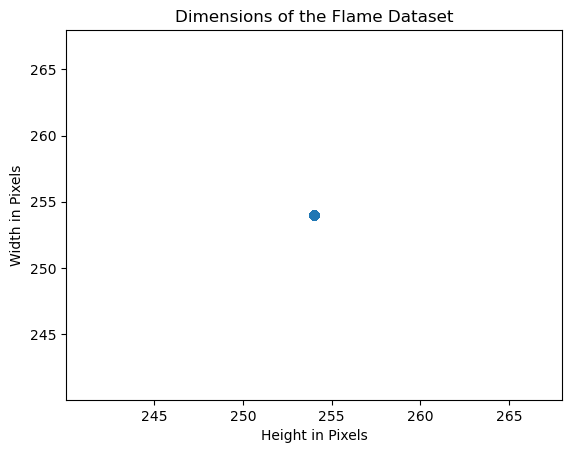

In [5]:
# Visualize the result
plt.scatter(image_dim_df['height'],image_dim_df['width'])
plt.xlabel('Height in Pixels')
plt.ylabel('Width in Pixels')
plt.title('Dimensions of the Flame Dataset')
plt.savefig('../figures/flame_dataset_image_dimensions.png')
plt.show()

In [6]:
# Test if there are any images that are not 255 X 255

((image_dim_df.height != 254) & (image_dim_df.width != 254)).any()

False

As shown above, all of the images in the data Fire_NoFire classification dataset have all been rescaled to 254x254 pixels

## Pixel Ranges

In [7]:
# Define function for getting pixel ranges

def get_range(img_path):
    im = Image.open(img_path)
    arr = np.array(im)
    min_val = arr.min()
    max_val = arr.max()
    return [min_val,max_val]

In [8]:
# Collect value ranges for the dataset
## Runtime entire dataset:
ranges = []

for s in ['Test','Training']:
    for c in ['Fire','No_Fire']:
        current_dir = os.path.join(root_path,s,c)
        file_seq = os.scandir(current_dir)
        for item in file_seq:
            img_val_range = get_range(item.path)
            ranges.append(img_val_range)

In [9]:
ranges_np = np.array(ranges)

In [10]:
# Add to the dataframe
image_dim_df['min_val'] = ranges_np[:,0]
image_dim_df['max_val'] = ranges_np[:,1]

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


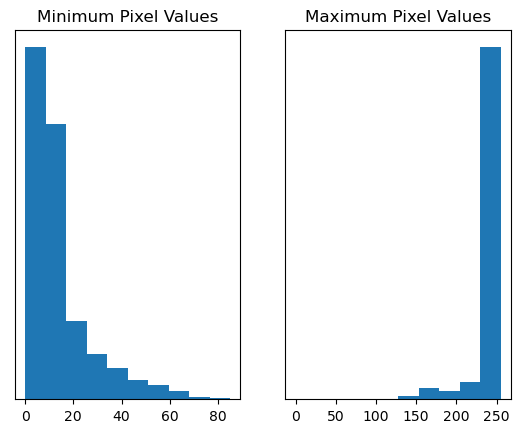

In [14]:
# Plot Histograms of minimums and maximums

fig, ax = plt.subplots(ncols=2)
ax[0].hist(image_dim_df.min_val)
ax[0].set_title('Minimum Pixel Values')
ax[0].set_yticks([])
ax[1].hist(image_dim_df.max_val)
ax[1].set_title('Maximum Pixel Values')
ax[1].set_yticks([])
ax[1].set_xticks([0,50,100,150,200,250])
fig.savefig('../figures/pixel_ranges.png')
fig.show()

In [15]:
image_dim_df[['min_val','max_val']].describe()

,min_val,max_val
count,47992.000000,47992.000000
mean,13.671279,244.164715
std,13.496918,21.795315
min,0.000000,0.000000
25%,5.000000,243.000000
50%,10.000000,253.000000
75%,16.000000,255.000000
max,85.000000,255.000000


Based on the above, the pixel ranges range from 0 to 255

## Image displaying

Below I will display the first 4 images in `Test/Fire`

Display a random image from:
- Test: Fire
- Test: No Fire
- Training: Fire
- Training: No Fire

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


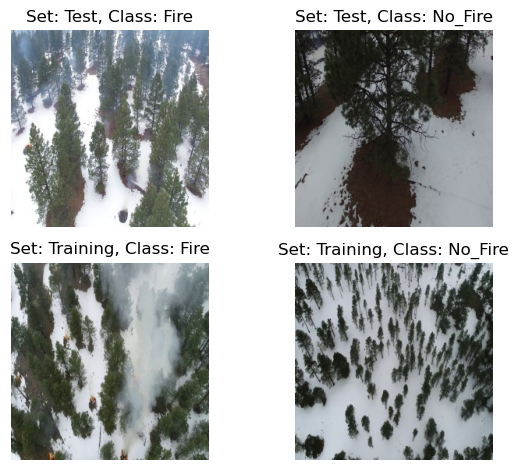

In [17]:
# Display th 4 random images
np.random.seed(1322)

fig, ax = plt.subplots(nrows=2, ncols=2)

test_train = ['Test','Training']
fire_noFire = ['Fire','No_Fire']
for row in range(2):
    for col in range(2):
        img_file = np.random.choice(os.listdir(os.path.join(root_path,test_train[row],fire_noFire[col])),1)[0]
        img_path = os.path.join(root_path,test_train[row],fire_noFire[col],img_file)
        img = Image.open(img_path)
        ax[row,col].imshow(img)
        ax[row,col].set_title(f'Set: {test_train[row]}, Class: {fire_noFire[col]}')
        ax[row,col].set_axis_off()

fig.tight_layout()
fig.savefig('../figures/example_images.png')
fig.show()

# Model Training and Scoring

## Pytorch CNN Model

I will now use Pytorch to build a CNN model for classifying the dataset

In [1]:
# Import the necessary modules to build the model
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

\<Explanation or learning rate choice\>

In [2]:
# Set model training parameters
batch_size = 500
learning_rate = 0.0001
epochs = 3

In [29]:
# Load the data
test_dir = os.path.join(root_path,'Test')
train_dir = os.path.join(root_path,'Training')

# Set the input data transformations, standardizing
transform = transforms.Compose(
    [
        transforms.ToTensor(), # convert to tensor, with values scaled to 0-1 per the documentation
        transforms.Resize((128,128),antialias=True), # Resize to 128 x 128 pixels
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize grey values within each channel
    ]    
)

# Define the ImageFolder objects using paths and transforms
train_folder = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=transform
)
test_folder = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=transform
)


In [30]:
# Check that the class labels have been set correctly
train_folder.classes

['Fire', 'No_Fire']

In [31]:
test_folder.classes

['Fire', 'No_Fire']

In [32]:
# Set random seed
np.random.seed(70103)

# Divide the dataset into batches
train_loader = torch.utils.data.DataLoader(
    dataset=train_folder,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_folder,
    batch_size=batch_size,
    shuffle=False
)

In [33]:
# Work out the convolved image shape for each layer

def output_shape(H,W,F,K,stride,padding):
    H_prime = ((H - F + 2*padding)/stride) + 1
    W_prime = ((W - K + 2*padding)/stride) + 1
    return [H_prime,W_prime]

## Layer 1
### Conv2d
shape = output_shape(128,128,5,5,1,2)
### MaxPool2d
shape = output_shape(shape[0],shape[1],2,2,2,0)
print('Layer 1:',shape[0],' x ',shape[1])

## Layer 2
### Conv2d
shape = output_shape(shape[0],shape[1],5,5,1,2)
### MaxPool2d
shape = output_shape(shape[0],shape[1],2,2,2,0)
print('Layer 2:',shape[0],' x ',shape[1])

Layer 1: 64.0  x  64.0
Layer 2: 32.0  x  32.0


In [34]:
# Convolutional neural network (two convolutional layers)
# This code was adapted from the code given in the week 2 coding demo
class UDA_CNN(nn.Module):
    def __init__(self, num_classes=2): # two classes, cats and dogs
        super(UDA_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                    in_channels = 3, # 3 in channels, R,G,B
                    out_channels = 16,
                    kernel_size=5,
                    stride=1,
                    padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16, 
                out_channels = 32, 
                kernel_size=5, 
                stride=1, 
                padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32*32*32, num_classes)
        
    def forward(self, x):
        # Layer 1: 
        # input: 100 images, 128 \times 128 pixels
        # output: 100 images 16 batches, 64 \times 64
        out = self.layer1(x) 
        # Layer 2: 
        # input: 100 images, 16 batches, 64 \times 64 
        # output: 100 images, 32 batches, 32 \times 32
        out = self.layer2(out)
        # Reshape: 
        # output: 100 images, 32 *32*32
        out = out.reshape(out.size(0), -1)
        # Reshape: 
        # output: 100 images, 2 classes probabilities 
        out = self.fc(out)
        return out
      
model = UDA_CNN()

In [35]:
# Set random seed
np.random.seed(70103)
random.seed(70103)
torch.manual_seed(70103)

# Loss function
criterion = nn.CrossEntropyLoss()
# optimizer to update network parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Define object for collecting training loss
training_loss = {
    'epoch':[],
    'step':[],
    'loss':[]
}

# Train the model
total_step = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Record the Loss
        training_loss['epoch'].append(epoch)
        training_loss['step'].append(i+1)
        training_loss['loss'].append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/3], Step [10/79], Loss: 0.3245
Epoch [1/3], Step [20/79], Loss: 0.2325
Epoch [1/3], Step [30/79], Loss: 0.1871
Epoch [1/3], Step [40/79], Loss: 0.1216
Epoch [1/3], Step [50/79], Loss: 0.0918
Epoch [1/3], Step [60/79], Loss: 0.0894
Epoch [1/3], Step [70/79], Loss: 0.0706
Epoch [2/3], Step [10/79], Loss: 0.0606
Epoch [2/3], Step [20/79], Loss: 0.0385
Epoch [2/3], Step [30/79], Loss: 0.0449
Epoch [2/3], Step [40/79], Loss: 0.0505
Epoch [2/3], Step [50/79], Loss: 0.0429
Epoch [2/3], Step [60/79], Loss: 0.0289
Epoch [2/3], Step [70/79], Loss: 0.0388
Epoch [3/3], Step [10/79], Loss: 0.0338
Epoch [3/3], Step [20/79], Loss: 0.0318
Epoch [3/3], Step [30/79], Loss: 0.0319
Epoch [3/3], Step [40/79], Loss: 0.0343
Epoch [3/3], Step [50/79], Loss: 0.0295
Epoch [3/3], Step [60/79], Loss: 0.0248
Epoch [3/3], Step [70/79], Loss: 0.0122


In [37]:
import pandas as pd
training_df = pd.DataFrame(training_loss)
training_df.to_csv('../training_loss_results/pytorch_model.csv',index=False)

In [38]:
# Test the model
model.eval()  # turn off batchnorm layer
with torch.no_grad(): # turn off gradient computation
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    
# Save the model checkpoint
torch.save(model.state_dict(), '../models/cnn_model_1.uda')

Test Accuracy of the model on the test images: 52.01346176163398 %


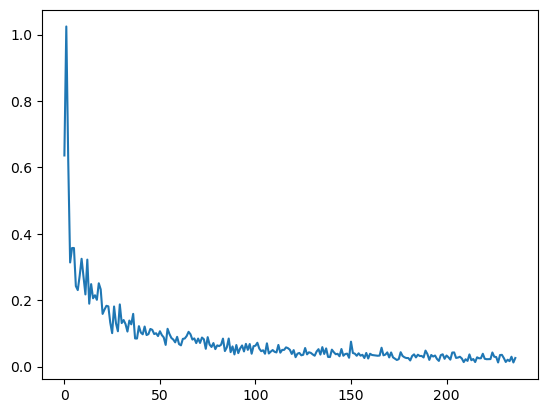

In [40]:
plt.plot(training_df.index,training_df.loss)
plt.show()

## DCNN Model

### Training

I will now proceed to fit an Xception Deep Convolutional Neural Network model as demonstrated in the paper by Shamsoshoara et al.

The script below has been adapted from the associated Github repository (see the reference paper). However, since I do not currently have access to a GPU-optimized machine, I have limited the training process to 20 Epochs, rather than the 40 used in the paper

In [51]:
# Make the necessary imports
import os.path
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [52]:
# Define the root path for the data
root_path = '../data/FLAME Dataset - Shamsoshoara/'

In [53]:
# Introduce training data augmentation including random flipping and random rotation
# This is a best practice to prevent model over-fitting
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )

In [54]:
# Define fitting parameters
image_shape = (256,256,3) # Image size from EDA above + 1 padding
batch_size = 32
epochs = 20
learning_rate = 0.001

In [55]:
# Define the metrics to keep track of during Stochastic Gradient Descent fitting
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.BinaryAccuracy(name='bin_accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

In [56]:
# Build Functional (Non-Squential) DCNN model per the Xception framework

## INPUT LAYER
inputs = keras.Input(shape=(None,None,3))
### Reshape to the same size as the training image shape
x = layers.experimental.preprocessing.Resizing(height=image_shape[0],width=image_shape[1])(inputs)
### Augment the data as above
x = data_augmentation(x)
### Scale the pixel values to 0-1 range
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

## HIDDEN LAYER
### Block1: Conv2D, BatchNormalization and Rectified Linear Unit Activation
x = layers.Conv2D(8, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

### previous block activation, for bypassing the next block
previous_block_activation = x

### Block2: [Sep Conv 2d, Batch Normalization, ReLU ](2X), Max Pooling 2D
x = layers.SeparableConv2D(8, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.SeparableConv2D(8, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

### Block2 bypass: Conv 2D
residual = layers.Conv2D(8, 1, strides=2, padding="same")(previous_block_activation)

### Add Block2 and Block2 bypass result
x = layers.add([x, residual])

### Block3: Sep Conv 2d, Batchnormalization, ReLU Activation
x = layers.SeparableConv2D(8, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

## OUTPUT LAYER:
x = layers.GlobalAveragePooling2D()(x)
activation = "sigmoid"
units = 1
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)


model = keras.Model(inputs, outputs, name="model_fire")

In [57]:
# Print out the Relative Class weights
dir_fire = root_path+'Training/Fire/'
dir_no_fire = root_path+'Training/No_Fire/'

# 0 is Fire and 1 is NO_Fire
fire = len([name for name in os.listdir(dir_fire) if os.path.isfile(os.path.join(dir_fire, name))])
no_fire = len([name for name in os.listdir(dir_no_fire) if os.path.isfile(os.path.join(dir_no_fire, name))])
total = fire + no_fire
weight_for_fire = (1 / fire) * total / 2.0
weight_for_no_fire = (1 / no_fire) * total / 2.0
class_weight = {0: weight_for_fire, 1: weight_for_no_fire}

print("Weight for class fire : {:.2f}".format(weight_for_fire))
print("Weight for class No_fire : {:.2f}".format(weight_for_no_fire))

Weight for class fire : 0.79
Weight for class No_fire : 1.37


As shown above, the trainig data is over-indexed in the Fire class. This may cause issue with precision and recall down the line

In [58]:
# Define the training and validation datasets
train_path = root_path + 'Training'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="training", seed=1337, image_size=(image_shape[0],image_shape[1]),
    batch_size=batch_size, shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="validation", seed=1337, image_size=(image_shape[0],image_shape[1]),
    batch_size=batch_size, shuffle=True
)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


In [59]:
# Pre-fetch
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

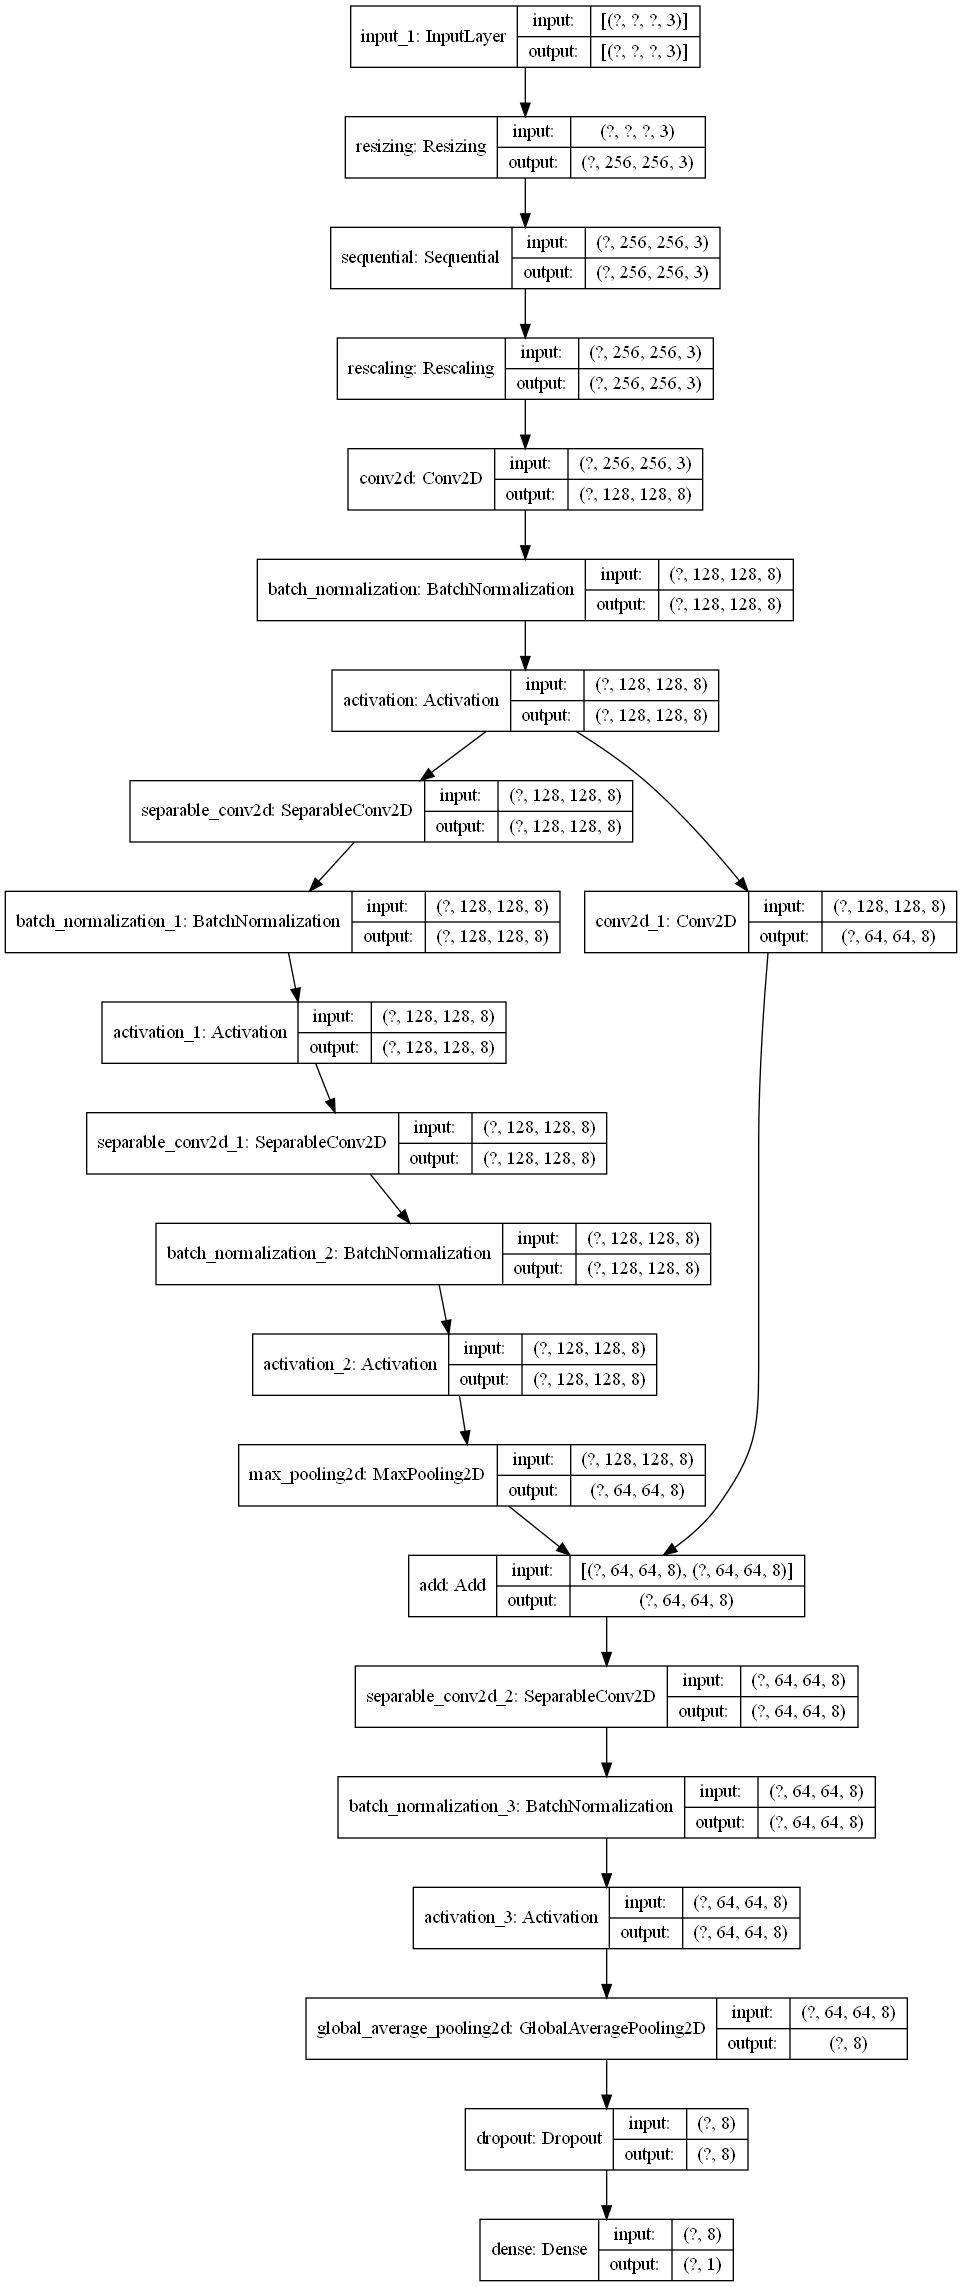

In [60]:
# Plot model
keras.utils.plot_model(model,show_shapes=True,to_file='../figures/dcnn_model.png')

In [61]:
# Define the model training callbacks
# This will essentially save a copy of the model at the end of each epoch
callbacks = [keras.callbacks.ModelCheckpoint("../models/dcnn_model_checkpoints/save_at_{epoch}.keras")]

In [62]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="binary_crossentropy",
    metrics=METRICS
    #loss_weights=[class_weight[0]]
)

In [63]:
# Fit the model and retrieve the result
# Runtime 335m
result = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    batch_size=batch_size
)

Epoch 1/20
985/985 [==============================] - 695s 705ms/step - loss: 0.3345 - tp: 8458.0000 - fp: 1097.0000 - tn: 18905.0000 - fn: 3040.0000 - accuracy: 2.5397e-04 - bin_accuracy: 0.8687 - precision: 0.8852 - recall: 0.7356 - auc: 0.9270 - val_loss: 0.2453 - val_tp: 2371.0000 - val_fp: 55.0000 - val_tn: 4961.0000 - val_fn: 488.0000 - val_accuracy: 0.0000e+00 - val_bin_accuracy: 0.9310 - val_precision: 0.9773 - val_recall: 0.8293 - val_auc: 0.9785
Epoch 2/20
985/985 [==============================] - 557s 566ms/step - loss: 0.2362 - tp: 9254.0000 - fp: 851.0000 - tn: 19151.0000 - fn: 2244.0000 - accuracy: 0.0069 - bin_accuracy: 0.9017 - precision: 0.9158 - recall: 0.8048 - auc: 0.9575 - val_loss: 0.1402 - val_tp: 2391.0000 - val_fp: 13.0000 - val_tn: 5003.0000 - val_fn: 468.0000 - val_accuracy: 5.0794e-04 - val_bin_accuracy: 0.9389 - val_precision: 0.9946 - val_recall: 0.8363 - val_auc: 0.9834
Epoch 3/20
985/985 [==============================] - 518s 526ms/step - loss: 0.2120 

In [64]:
# Save the model
model_file_path = "../models/dcnn_model.keras"
model.save(model_file_path)

### Analysis of Results

#### Analysis of DCNN Layers

In this section, I take a single example "Fire" classed image from the trainging set, and apply each of the layers above to see the effects

In [63]:
# Import necessary packages
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns

In [64]:
# Load the model
model = load_model('../models/dcnn_model.keras')

In [65]:
# Show all of the layer objects in the model
model.layers

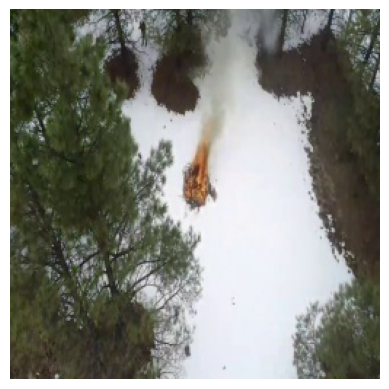

In [66]:
# Load in and display the exaple image, with it's model prediction 
img_path = '../data/FLAME Dataset - Shamsoshoara/Training/Fire/resized_frame17.jpg'
img = Image.open(img_path)
img_array = np.asarray(img)
plt.imshow(img_array)
plt.axis('off')
plt.savefig('../figures/model_layers_example/input_image.png')
plt.show()

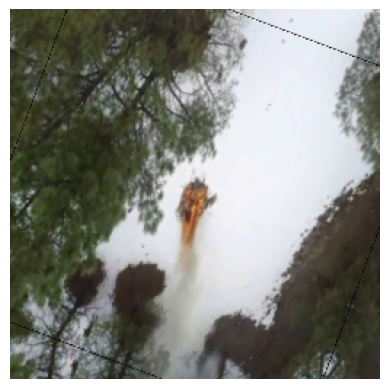

In [67]:
# Input Layer
x = model.layers[2](np.expand_dims(img_array,0))
x = model.layers[3](x)

plt.imshow(x[0,:,:,:])
plt.axis('off')
plt.savefig('../figures/model_layers_example/after_input_layer.png')
plt.show()

In [68]:
def channel_figs(x,fig_name=None,figsize=(8,1)):
    fig, ax = plt.subplots(figsize=figsize,nrows=1,ncols=8)
    for column in range(8):
        for row in range(1):
            channel = (row*4) + column
            arr = x[0,:,:,channel]
            sns.heatmap(
                data = arr,
                cbar=False,
                yticklabels=False,
                xticklabels=False,
                ax=ax[column]
            )
            ax[column].set_title(f'Output Channel: {str(channel+1)}')
    if fig_name is not None:
        fig.savefig(fig_name)
    
    fig.set_tight_layout(True)
    fig.show()

In [69]:
# Hidden Layer - Block 1
### 2D convolutional layer
x = model.layers[4](x)
x = model.layers[5](x)
x = model.layers[6](x)

In [70]:
# Save block 2 bypass
x_checkpoint = x

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


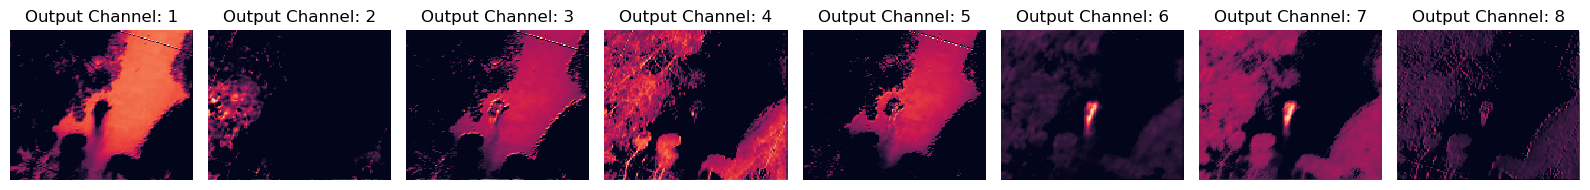

In [71]:
channel_figs(x,figsize=(16,2),fig_name='../figures/model_layers_example/hidden_conv_layer_1.png')

In [72]:
# Hidden Layer Block 2
x = model.layers[7](x) # Sep Conv 2d
x = model.layers[8](x) # Batch Normalization
x = model.layers[9](x) # ReLu Activation

x = model.layers[10](x) # Sep Conv 2d
x = model.layers[11](x) # Batch Normalization
x = model.layers[12](x) # ReLu Activation

x = model.layers[13](x) # MaxPooling

In [73]:
# Block 2 bypass
residual = model.layers[14](x_checkpoint)

In [74]:
# Addition
x = model.layers[15]([x,residual])

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


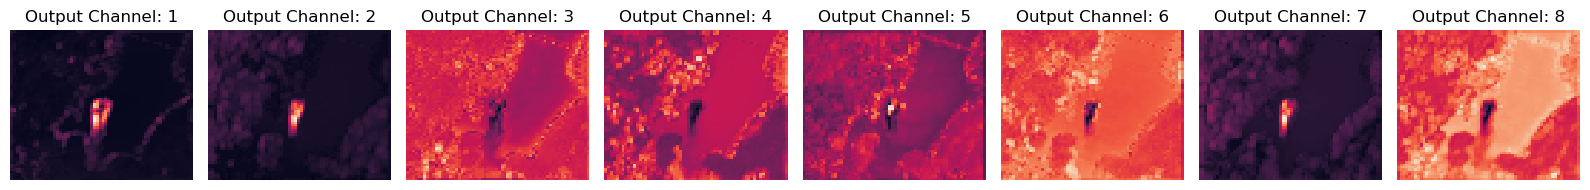

In [75]:
# Save Fig
channel_figs(
    x,
    figsize=(16,2),
    fig_name='../figures/model_layers_example/hidden_conv_layer_2.png'
    )

In [76]:
# Block 3
x = model.layers[16](x) # Sep Conv 2d
x = model.layers[17](x) # Batch Normalization
x = model.layers[18](x) # ReLU Activation

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


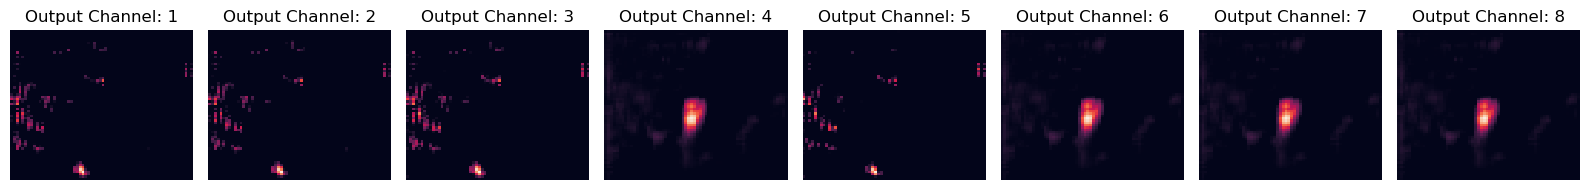

In [77]:
channel_figs(
    x,
    figsize=(16,2),
    fig_name='../figures/model_layers_example/hidden_conv_layer_3.png'
    )

In [78]:
# Output layer
output_array_1 = model.layers[19](x) # Global Average Pooling 2d
output_array_1.numpy()

array([[0.0279386 , 0.02377858, 0.0354797 , 1.3820202 , 0.01877639,
        1.3109157 , 1.2883549 , 1.2527789 ]], dtype=float32)

In [79]:
# Prediction
prediction = model.layers[20](output_array_1)
prediction = model.layers[21](prediction)
prediction = 1 - prediction.numpy()[0][0]
print(f'P(label=Fire) = {str(round(prediction*100,4))}%')

P(label=Fire) = 99.9982%


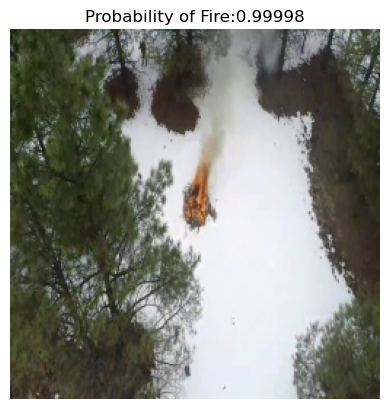

In [81]:
# Load in and display the exaple image, with it's model prediction 
#img_path = '../data/FLAME Dataset - Shamsoshoara/Training/Fire/resized_frame17.jpg'
#img = Image.open(img_path)
#img_array = np.asarray(img)
prediction = model.predict(np.expand_dims(img_array,0))[0][0]
plt.imshow(img_array)
plt.title(f'Probability of Fire:{str(round(1-prediction,5))}')
plt.axis('off')
plt.savefig('../figures/model_layers_example/result.png')
plt.show()

#### Training Loss and KPIs

In [65]:
import pickle
import numpy as np

# Plot and export the training results
## Define functions for plotiing the loss per epoch and other metrics
def plot_training(result, type_model, layers_len):
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    epochs = len(result.history['accuracy'])
    ax[0].set_title("Loss", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[0].set_ylabel("Loss", fontsize=14, fontweight="bold")
    ax[0].plot(np.arange(1, epochs+1), result.history['loss'], label='Loss', linewidth=2.5, linestyle='-', marker='o',
               markersize='10', color='red')
    ax[0].plot(np.arange(1, epochs+1), result.history['val_loss'], label='Validation_loss', linewidth=2.5, marker='x',
               linestyle='--', markersize='10', color='blue')
    ax[0].grid(True)
    ax[0].legend(prop={'size': 14, 'weight': 'bold'})
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.3)

    ax[1].set_title("Accuracy", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[1].set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    ax[1].plot(np.arange(1, epochs+1), result.history['bin_accuracy'], label='Accuracy', linewidth=2.5, linestyle='-',
               marker='o', markersize='10', color='red')
    ax[1].plot(np.arange(1, epochs+1), result.history['val_bin_accuracy'], label='Validation_accuracy', linewidth=2.5,
               linestyle='--', marker='x', markersize='10', color='blue')
    ax[1].grid(True)
    ax[1].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    file_figobj = '../figures/%s_%d_EPOCH_%d_layers_opt.fig.pickle' % (type_model, epochs, layers_len)
    file_pdf = '../figures/%s_%d_EPOCH_%d_layers_opt.pdf' % (type_model, epochs, layers_len)

    pickle.dump(fig, open(file_figobj, 'wb'))
    fig.savefig(file_pdf, bbox_inches='tight')
    fig.show()

def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall', 'bin_accuracy']
    epochs = len(history.history['accuracy'])
    (fig, ax) = plt.subplots(1, 5, figsize=(20, 5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        ax[n].plot(history.epoch, history.history[metric], linewidth=2.5, linestyle='-', marker='o', markersize='10',
                   color='blue', label='Train')
        ax[n].plot(history.epoch, history.history['val_'+metric], linewidth=2.5, linestyle='--', marker='x',
                   markersize='10', color='blue', label='Val')
        ax[n].grid(True)
        # plt.xlabel('Epoch')
        # plt.ylabel(name)
        ax[n].set_xlabel("Epoch", fontsize=14, fontweight="bold")
        ax[n].set_ylabel(name, fontsize=14, fontweight="bold")
        ax[n].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
        ax[n].tick_params(axis='both', which='major', labelsize=15)

    file_figobj = '../figures/Metric_%d_EPOCH.fig.pickle' % epochs
    file_pdf = '../figures/Metric_%d_EPOCH.pdf' % epochs

    pickle.dump(fig, open(file_figobj, 'wb'))
    fig.savefig(file_pdf, bbox_inches='tight')
    fig.show()

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


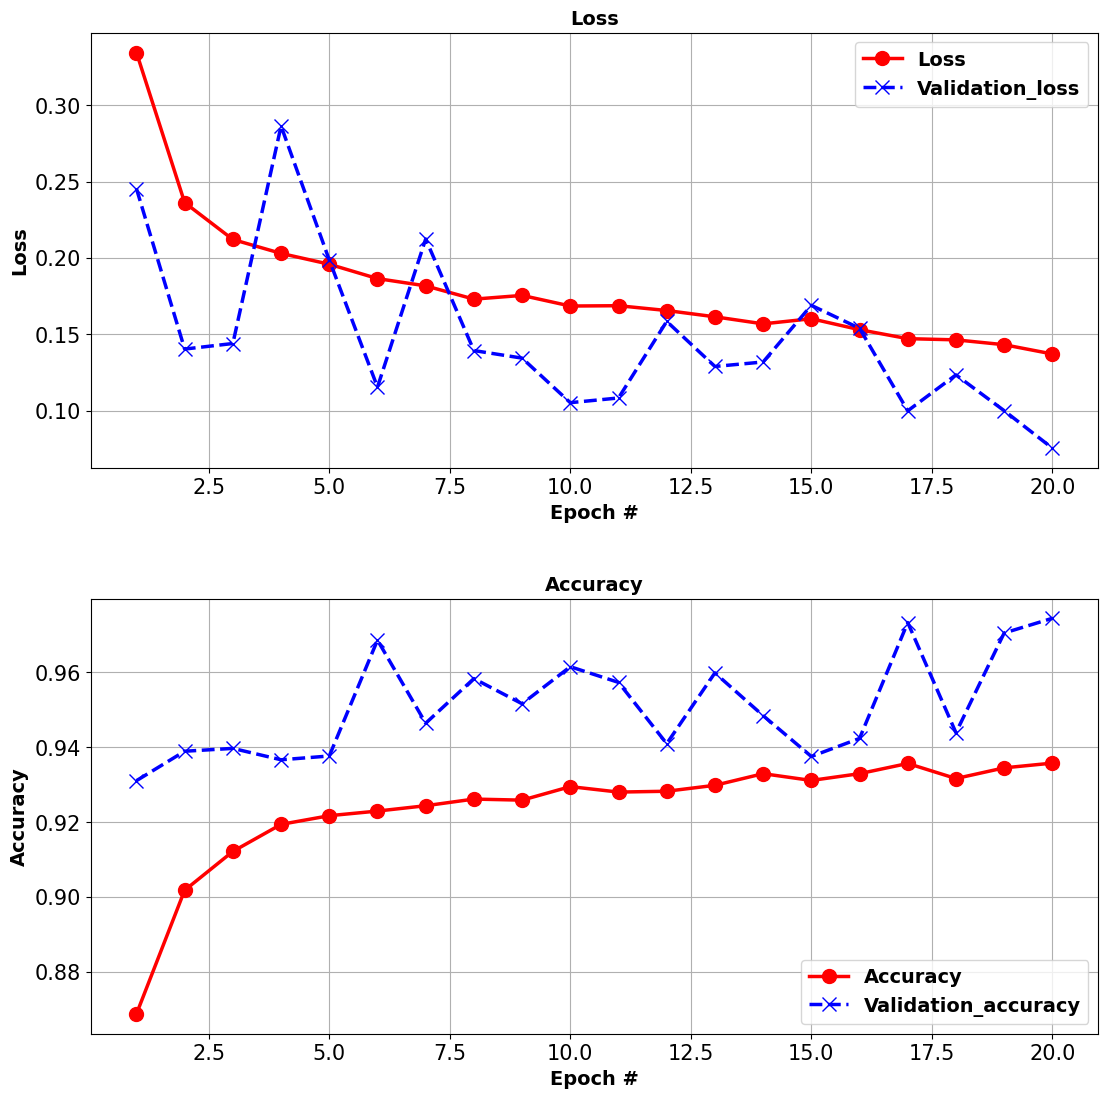

In [66]:
# Execute both
plot_training(result,'Xception DCNN Model',len(model.layers))


c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


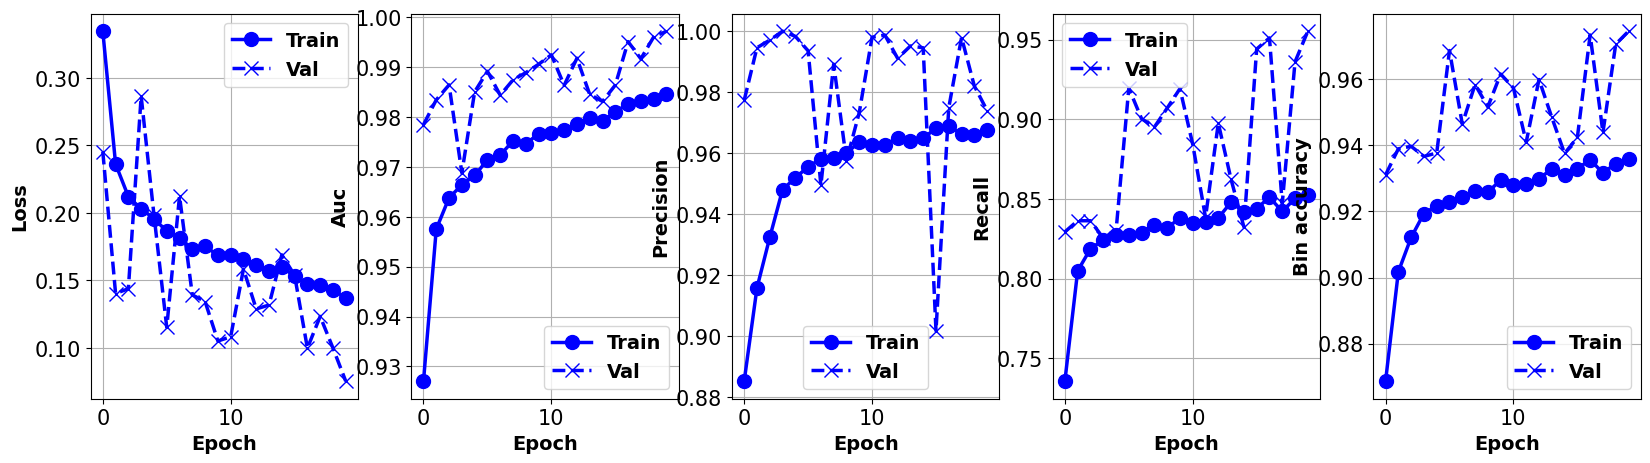

In [67]:
plot_metrics(result)

In [68]:
# Save the model history
history = result.history
pickle.dump(history,open('../models/dcnn_model_training.hist','wb'))

#### Scoring against the test set

Using the model created above, I will now classify the data in the Test repository of the data, and produce a confusion matrix

In [69]:
# import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import random
import pickle
import itertools
from skimage.io import imshow
import matplotlib.pyplot as plt

In [70]:
# Set the path to the dataset
root_path = '../data/FLAME Dataset - Shamsoshoara/'
# root_path = '../data/FLAME_Dataset_subset/'

In [71]:
# Set other parameters
batch_size=32
image_size = (256,256)
epochs=2

In [72]:
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=root_path + 'Test',
    seed = 1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 8617 files belonging to 2 classes.


In [73]:
# Load the final output model
model = load_model('../models/dcnn_model.keras')

In [74]:
# Evaluate this model against the training set
eval_result = model.evaluate(test_ds,batch_size=batch_size)

270/270 [==============================] - 114s 422ms/step - loss: 1.4413 - tp: 2859.0000 - fp: 3252.0000 - tn: 1885.0000 - fn: 621.0000 - accuracy: 0.0038 - bin_accuracy: 0.5505 - precision: 0.4678 - recall: 0.8216 - auc: 0.6649


In [75]:
# Print the result
print('Note that Positive indicates "Fire"')
for i in range(len(eval_result)):
    print(model.metrics_names[i]+': '+str(eval_result[i]))

Note that Positive indicates "Fire"
loss: 1.4412615299224854
tp: 2859.0
fp: 3252.0
tn: 1885.0
fn: 621.0
accuracy: 0.003829639172181487
bin_accuracy: 0.5505396127700806
precision: 0.4678448736667633
recall: 0.8215517401695251
auc: 0.6649035215377808


In [76]:
# Define function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    fig_conf = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12, fontweight='bold')
    plt.xlabel('Predicted label', size=12, fontweight='bold')
    # file_pdf = 'Output/Figures/confusion_matrix.pdf'
    file_figobj = '../figures/confusion_matrix.fig.pickle'
    pickle.dump(fig_conf, open(file_figobj, 'wb'))

Confusion matrix, without normalization
[[2859  621]
 [3252 1885]]


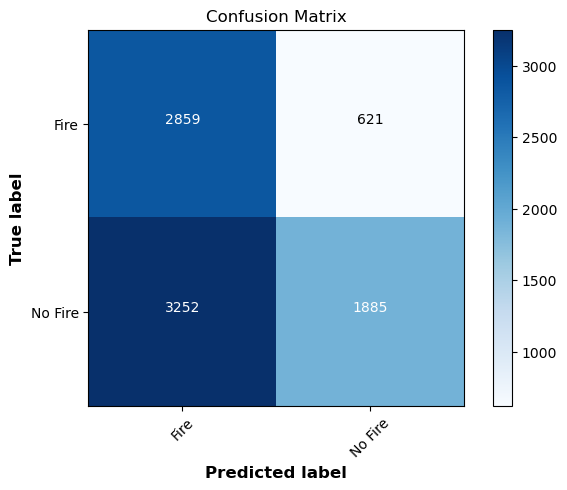

In [77]:
# Plot the confusion matrix for evaluation result
eval_result_dict = dict(zip(model.metrics_names,eval_result))
cm_plot_labels = ['Fire','No Fire']
cm = np.array(
    [
        [eval_result_dict['tp'],eval_result_dict['fn']],
        [eval_result_dict['fp'],eval_result_dict['tn']]
    ],
    dtype=int
)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')


(-0.5, 253.5, 253.5, -0.5)

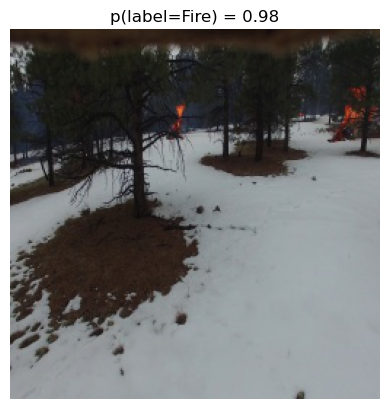

In [78]:
# Plot an example image from the test set along with the labels
test_image = 'Test/Fire/resized_test_fire_frame192.jpg'
img = img_to_array(load_img(root_path+test_image))
img_batch = tf.expand_dims(img,0)
prediction = model.predict(img_batch)[0][0]
plt.imshow(tf.cast(img,tf.int32))
plt.title('p(label=Fire) = %.2f'%((1-prediction)))
plt.axis('off')

#### Scoring against out of Sample data

I will now aim to test the model against images that are completely out of sample. For this I will use the images from the Kaggle Fire dataset.

In [44]:
# Import necessary libraries
from PIL import Image
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import itertools
import pickle

In [39]:
# Map out the folder structure of the Kaggle flame dataset
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}-{}'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        filecount = len(files)
        if filecount>0:
            print(f'{subindent}-{filecount} files')

list_files(data_path)

-
-Fire
    -755 files
-No_Fire
    -243 files


c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


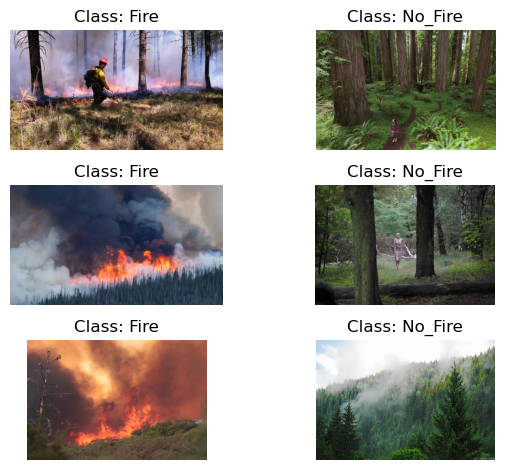

In [29]:
# Plot 2 impages for Flame and No Flame
data_path = '../data/Kaggle FIRE dataset/fire_dataset/'
np.random.seed(30224)

fig,ax = plt.subplots(ncols=2,nrows=3)
for s in range(2):
    label = ['Fire','No_Fire'][s]
    img_paths = np.random.choice(
        os.listdir(
            data_path+label
        ),
        3
    )
    for i in range(3):
        img = Image.open(os.path.join(data_path,label,img_paths[i]))
        ax[i,s].imshow(img)
        ax[i,s].set_axis_off()
        ax[i,s].set_title(f'Class: {label}')
fig.tight_layout()
fig.show()

In [33]:
# Create tensorflow data reader object
oos_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path,
    seed = 1337,
    batch_size=32,
    shuffle=False
)

Found 998 files belonging to 2 classes.


In [34]:
# Evaluate the predictions on the out of sample set
eval_result_oos = model.evaluate(oos_ds)

32/32 [==============================] - 26s 799ms/step - loss: 5.0970 - tp: 118.0000 - fp: 37.0000 - tn: 718.0000 - fn: 125.0000 - accuracy: 0.1994 - bin_accuracy: 0.8377 - precision: 0.7613 - recall: 0.4856 - auc: 0.7449


In [35]:
# Print the result
print('Note that Positive indicates "Fire"')
for i in range(len(eval_result_oos)):
    print(model.metrics_names[i]+': '+str(eval_result_oos[i]))

Note that Positive indicates "Fire"
loss: 5.097003936767578
tp: 118.0
fp: 37.0
tn: 718.0
fn: 125.0
accuracy: 0.19939880073070526
bin_accuracy: 0.8376753330230713
precision: 0.7612903118133545
recall: 0.4855967164039612
auc: 0.744940459728241


In [40]:
# Define function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    fig_conf = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12, fontweight='bold')
    plt.xlabel('Predicted label', size=12, fontweight='bold')
    # file_pdf = 'Output/Figures/confusion_matrix.pdf'
    file_figobj = '../figures/confusion_matrix_oos.fig.pickle'
    pickle.dump(fig_conf, open(file_figobj, 'wb'))

Confusion matrix, without normalization
[[118 125]
 [ 37 718]]


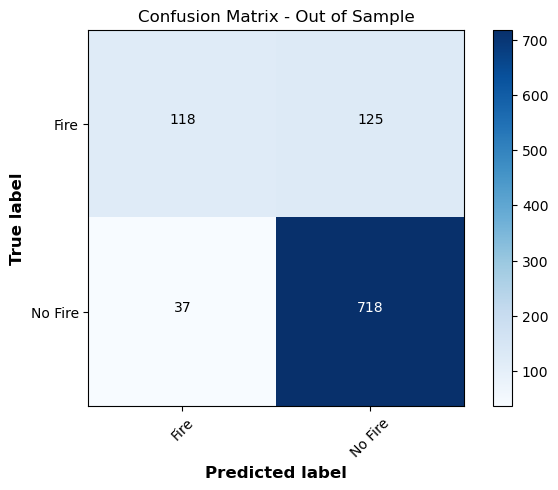

In [45]:
# Plot the confusion matrix for evaluation result
eval_result_dict = dict(zip(model.metrics_names,eval_result_oos))
cm_plot_labels = ['Fire','No Fire']
cm = np.array(
    [
        [eval_result_dict['tp'],eval_result_dict['fn']],
        [eval_result_dict['fp'],eval_result_dict['tn']]
    ],
    dtype=int
)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix - Out of Sample')